#  Assignment: Handwritten digits dataset

The dataset that you will use in this assignment is the [*digits* dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) which contains $1797$ images of $10$ hand-written digits. The digits have been preprocessed so that $32 \times 32$ bitmaps are divided into non-overlapping blocks of $4 \times 4$ and the number of on pixels are counted in each block. This generates an input matrix of $8 \times 8$ where each element is an integer in the range of $[0, ..., 16]$. This reduces dimensionality and gives invariance to small distortions.

For further information on NIST preprocessing routines applied to this data, see M. D. Garris, J. L. Blue, G. T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C. L. Wilson, *NIST Form-Based Handprint Recognition System*, NISTIR 5469, 1994.

As before, use the `sklearn`'s data uploading routines to load the dataset and get the data fields.

**Task:** For the rest of the practical, apply the data preprocessing techniques, implement and evaluate the classification models on the digits dataset using the steps that you applied above to the iris dataset.

In [0]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Uploading the dataset

In [0]:
# Uploading the dataset

from sklearn import datasets
digits = datasets.load_digits()
print(list(digits.keys()))
print(digits.target_names)

['data', 'target', 'target_names', 'images', 'DESCR']
[0 1 2 3 4 5 6 7 8 9]


In [0]:
X, y = digits["data"], digits["target"]
X.shape

(1797, 64)

In [0]:
y.shape

(1797,)

Label: 3


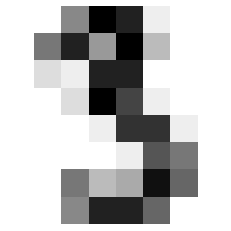

In [0]:
some_digit = X[3]
print("Label: {}".format(y[3]))
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [0]:
np.random.seed(1)

Looking at which pixels are the most important for each digit by computing the average value at that pixel across all the images.

An example for digit 3:


In [0]:
np.random.seed(1)
ix_3 = np.where(digits["target"] == 3)
X_3 = X[ix_3]
X_3.shape

(183, 64)

In [0]:
# Average value per pixel
X_3_avg = np.sum(X_3, axis=0) / X_3.shape[0]
X_3_avg.shape

(64,)

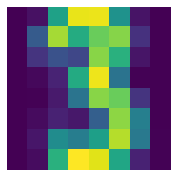

In [0]:
fig = plt.figure(figsize=(3,3))
plt.imshow(X_3_avg.reshape((8, 8)))
plt.axis('off')
plt.show()

Now for all digits

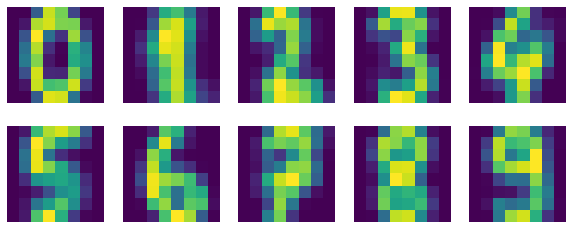

In [0]:
fig=plt.figure(figsize=(10, 4))

index = 1
columns = 5
rows = 2

for i in range(1, 11):
    X_i = X[np.where(digits['target'] == i-1)]
    X_i_avg = np.average(X_i, axis=0)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(X_i_avg.reshape((8,8)))


plt.show()

Difference between the given digit and the all the other digits combined, i.e. which parts of the image for a specific digit are extra important compared to all the other images. For example, 0 is special because, unlike other images, it has a hole in the middle so the middle of the image has higher-valued (lighter) pixels relative to the other digits.

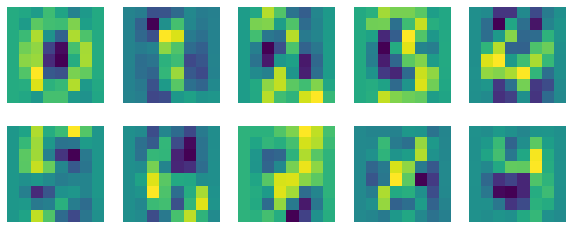

In [0]:
fig=plt.figure(figsize=(10, 4))

index = 1
columns = 5
rows = 2

for i in range(1, 11):
    X_i = X[np.where(digits['target'] == i-1)]
    X_i_avg = np.average(X_i, axis=0)
    X_i_diff = X_i_avg - np.average(X[np.where(digits['target'] != i-1)], axis=0)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(X_i_diff.reshape((8,8)))


plt.show()

## Splitting the data into training and test subsets

Apply stratified random splitting by digit so that each digit is equally represented in train and test sets.

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
split.get_n_splits(X, y)
print(split)       

for train_index, test_index in split.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

StratifiedShuffleSplit(n_splits=1, random_state=2, test_size=0.2,
            train_size=None)
TRAIN: 1437 TEST: 360
(1437, 64) (1437,) (360, 64) (360,)


This returns the following proportions of each digit.

In [0]:
import pandas as pd

def subset_proportions(subset):
    props = {}
    for value in set(subset):
        data_value = [i for i in subset if i==value]
        props[value] = len(data_value) / len(subset)
    return props

   
compare_props = pd.DataFrame({
    "Overall": subset_proportions(digits["target"]),
    "Stratified tr": subset_proportions(y_train),
    "Stratified ts": subset_proportions(y_test),
})
compare_props["Strat. tr %error"] = 100 * compare_props["Stratified tr"] / compare_props["Overall"] - 100
compare_props["Strat. ts %error"] = 100 * compare_props["Stratified ts"] / compare_props["Overall"] - 100

compare_props.sort_index()

,Overall,Stratified tr,Stratified ts,Strat. tr %error,Strat. ts %error
0,0.099054,0.098817,0.100000,-0.239263,0.955056
1,0.101280,0.101601,0.100000,0.316594,-1.263736
2,0.098497,0.098817,0.097222,0.324357,-1.294727
3,0.101836,0.101601,0.102778,-0.231584,0.924408
4,0.100723,0.100905,0.100000,0.179933,-0.718232
5,0.101280,0.100905,0.102778,-0.370506,1.478938
6,0.100723,0.100905,0.100000,0.179933,-0.718232
7,0.099610,0.099513,0.100000,-0.097969,0.391061
8,0.096828,0.096729,0.097222,-0.101984,0.407088
9,0.100167,0.100209,0.100000,0.041754,-0.166667


## Binary classification

### Perceptron

Creating 10 perceptrons for the 10 classes of digits.

In [0]:
# Create binary labels to separate each digit
y_train_digit = [y_train == i for i in digits.target_names]
y_test_digit = [y_test == i for i in digits.target_names]
y_train_digit

[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ...,  True, False,  True]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([ True, False,  True, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False,  True, False, ..., False,  True, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [0]:
# Fit each digit's perceptron
from sklearn.linear_model import SGDClassifier

sgds = []
for i in digits.target_names:
  sgd = SGDClassifier(max_iter=5, tol=None, random_state=42,
                   loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
  sgd.fit(X_train, y_train_digit[i])
  sgds.append(sgd)

### Logistic regression

In [0]:
from sklearn.linear_model import LogisticRegression

log_regs = []
for i in digits.target_names:
  log_reg = LogisticRegression()
  log_reg.fit(X_train, y_train_digit[i])
  log_regs.append(log_reg)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

gnbs = []
for i in digits.target_names:
  gnb = GaussianNB() 
  gnb.fit(X_train, y_train_digit[i])
  gnbs.append(gnb)

## Evaluation

In [0]:
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

log_reg_scores = []
gnb_scores = []
sgd_scores = []

for i in digits.target_names:
  print(i)
  log_reg_score = cross_val_score(log_regs[i], X_train, y_train_digit[i], cv=5, scoring="accuracy")
  gnb_score = cross_val_score(gnbs[i], X_train, y_train_digit[i], cv=5, scoring="accuracy")
  sgd_score = cross_val_score(sgds[i], X_train, y_train_digit[i], cv=5, scoring="accuracy")
  log_reg_scores.append(log_reg_score)
  gnb_scores.append(gnb_score)
  sgd_scores.append(sgd_score)
  print(log_reg_score)
  print(gnb_score)
  print(sgd_score)
  print()

0
[1.         1.         1.         0.99303136 1.        ]
[0.99652778 0.99305556 0.97909408 0.97909408 0.98954704]
[1.         0.99652778 1.         0.99303136 0.99651568]

1
[0.96539792 0.95470383 0.98954704 0.97212544 0.96864111]
[0.69896194 0.72125436 0.47735192 0.65853659 0.55400697]
[0.94463668 0.95121951 0.98954704 0.94773519 0.96515679]

2
[1.         1.         1.         0.99651568 1.        ]
[0.73958333 0.74305556 0.66898955 0.76655052 0.70731707]
[0.99652778 1.         1.         0.9825784  0.99651568]

3
[0.98961938 0.98954704 0.9825784  0.98606272 0.9825784 ]
[0.66089965 0.68989547 0.71428571 0.728223   0.75261324]
[0.98269896 0.98954704 0.97560976 0.97560976 0.96515679]

4
[0.99652778 0.99652778 1.         1.         0.99303136]
[0.86458333 0.82638889 0.85714286 0.81533101 0.90940767]
[0.99305556 0.98958333 0.98954704 0.99303136 0.98954704]

5
[0.99305556 0.97916667 0.99651568 0.98606272 0.98606272]
[0.62152778 0.69097222 0.58188153 0.68292683 0.66202091]
[0.98263889 0.

## Baselines

In [0]:
from sklearn.base import BaseEstimator

class NotXClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

not_digit_clf = NotXClassifier()
not_digit_clf_scores = []
for i in digits.target_names:
  score = cross_val_score(not_digit_clf, X_train, y_train_digit[i], cv=5, scoring="accuracy")
  print(score)
  not_digit_clf_scores.append(score)

[0.89930556 0.85763889 0.91637631 0.91289199 0.91986063]
[0.87847222 0.91319444 0.90243902 0.89547038 0.90243902]
[0.92013889 0.92361111 0.90243902 0.87108014 0.88850174]
[0.86805556 0.89930556 0.93031359 0.91986063 0.87456446]
[0.92013889 0.88194444 0.90940767 0.87108014 0.91289199]
[0.90625    0.90277778 0.8815331  0.90940767 0.89547038]
[0.89583333 0.92361111 0.8815331  0.90243902 0.89198606]
[0.88541667 0.92361111 0.90592334 0.87804878 0.90940767]
[0.90277778 0.89930556 0.89198606 0.91986063 0.90243902]
[0.92361111 0.875      0.87804878 0.91986063 0.90243902]


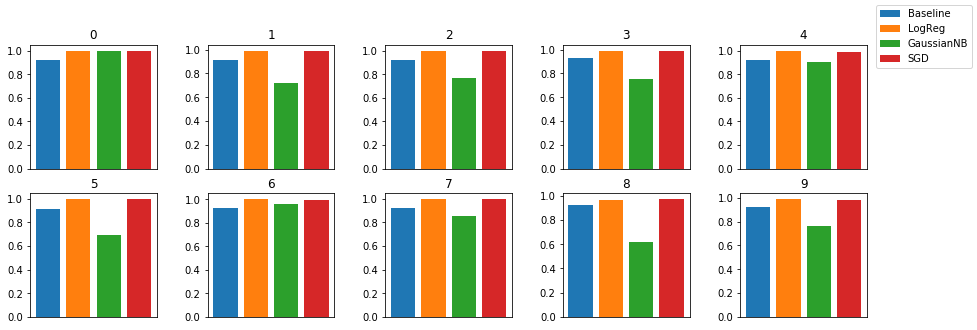

In [0]:
fig=plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

index = 1
columns = 5
rows = 2

for i in range(1, 11):
  ax = fig.add_subplot(rows, columns, i)
  index += 1
  ax.bar(0, not_digit_clf_scores[i-1])
  ax.bar(1, log_reg_scores[i-1])
  ax.bar(2, gnb_scores[i-1])
  ax.bar(3, sgd_scores[i-1])
  ax.title.set_text(i-1)
  ax.tick_params(axis='x', bottom=False, labelbottom=False)
    
fig.legend(('Baseline', 'LogReg', 'GaussianNB', 'SGD'))
plt.show()

### Confusion matrices

[[1294    1]
 [   1  141]]
[[1261   30]
 [  13  133]]
[[1294    1]
 [   0  142]]
[[1280   11]
 [   9  137]]
[[1292    0]
 [   4  141]]
[[1283    9]
 [   8  137]]
[[1289    3]
 [   5  140]]
[[1291    3]
 [   4  139]]
[[1261   37]
 [  37  102]]
[[1276   17]
 [  16  128]]


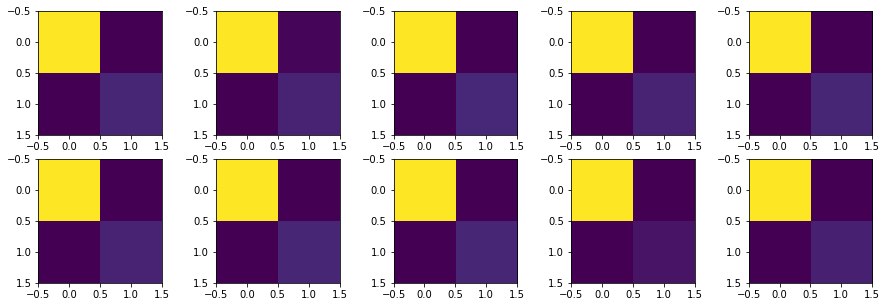

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

fig=plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

index = 1
columns = 5
rows = 2


for i in range(1, 11):
  y_train_pred = cross_val_predict(log_regs[i-1], X_train, y_train_digit[i-1], cv=5)
  fig.add_subplot(rows, columns, i)
  print(confusion_matrix(y_train_digit[i-1], y_train_pred))
  plt.imshow(confusion_matrix(y_train_digit[i-1], y_train_pred))
  index += 1


plt.show()